In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

In [70]:
data = pd.read_csv("BreastCancer_Data.csv")

In [71]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Checking for missing values

In [72]:
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

All features are complete. No missing data as seen above.

## Dropping unimportant features and reassigning targets

In [73]:
data.drop('id', axis=1)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [74]:
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

## Exploratory Data Analysis

In [75]:
data.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [76]:
M = data[data['diagnosis'] != 0]
B = data[data['diagnosis'] == 0]

## Getting count of Malignant and Benign tumors

In [77]:
trace = go.Bar(x = (len(M), len(B)), y = ['Malignant', 'Benign'], orientation = 'h', opacity = 0.8, marker = dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))
layout = dict(title = 'Count of diagnosis variable')
fig = dict(data = [trace], layout = layout)
py.iplot(fig)

## Percentage Distribution of Diagnosis variables

In [78]:
trace = go.Pie(labels = ['benign','malignant'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue', 'gold'], 
                           line=dict(color='#000000', width=1.5)))
layout = dict(title =  'Distribution of diagnosis variable')           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [42]:
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [43]:
plot_distribution('radius_mean', .5)
plot_distribution('texture_mean', .5)
plot_distribution('perimeter_mean', 5)
plot_distribution('area_mean', 10)

In [44]:
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)

In [45]:
plot_distribution('radius_worst', .5)
plot_distribution('texture_worst', .5)
plot_distribution('perimeter_worst', 5)
plot_distribution('area_worst', 10)

## Correlation Matrix

In [50]:
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#conversion to array
corr_array = np.array(correlation)

In [51]:
#Plotting

trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2, ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

## Checking correlation between few features by pairs
Positive Correlation Features

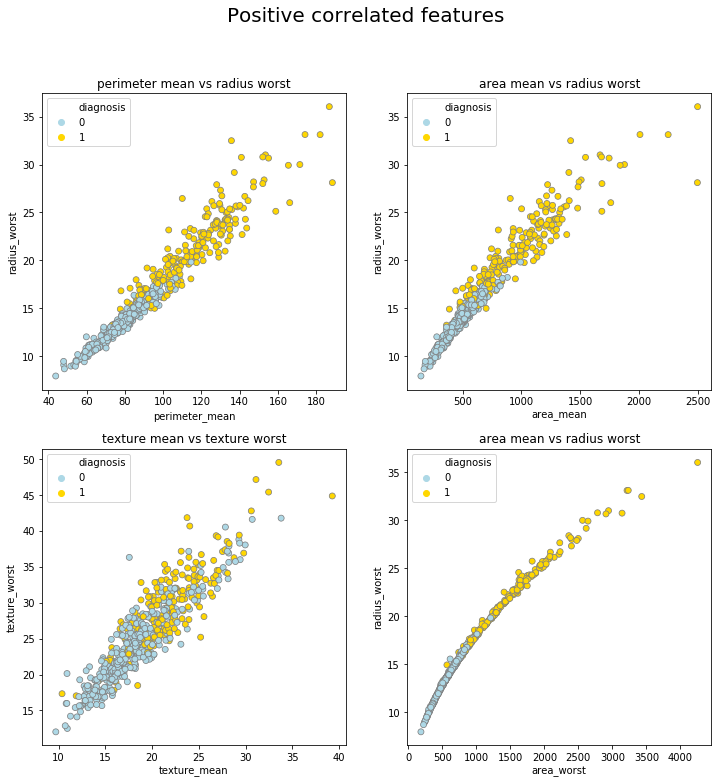

In [52]:
#Seaborn Visualization
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['perimeter_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['texture_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['area_worst'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()

## Uncorrelated Features

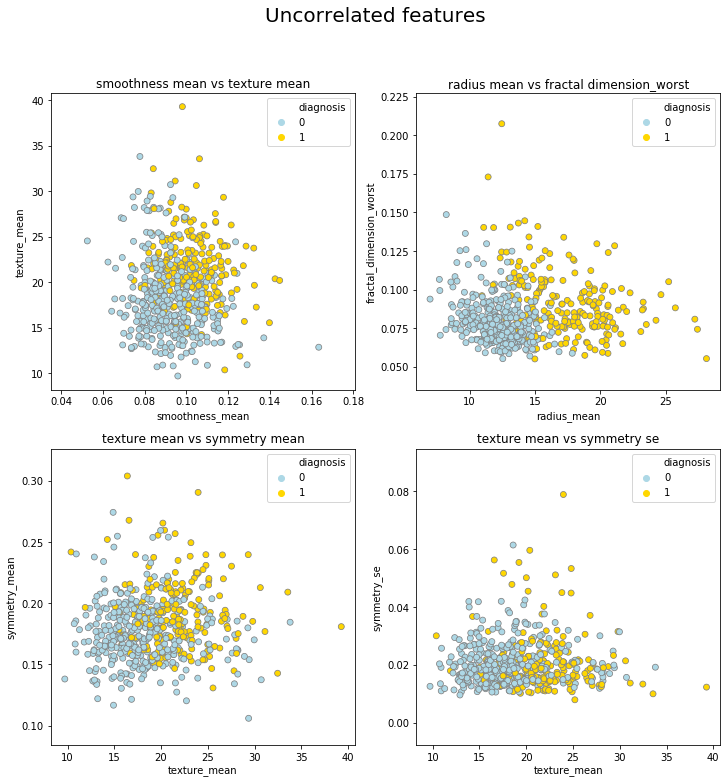

In [53]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['smoothness_mean'], y = data['texture_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

## Negative Correlated Features

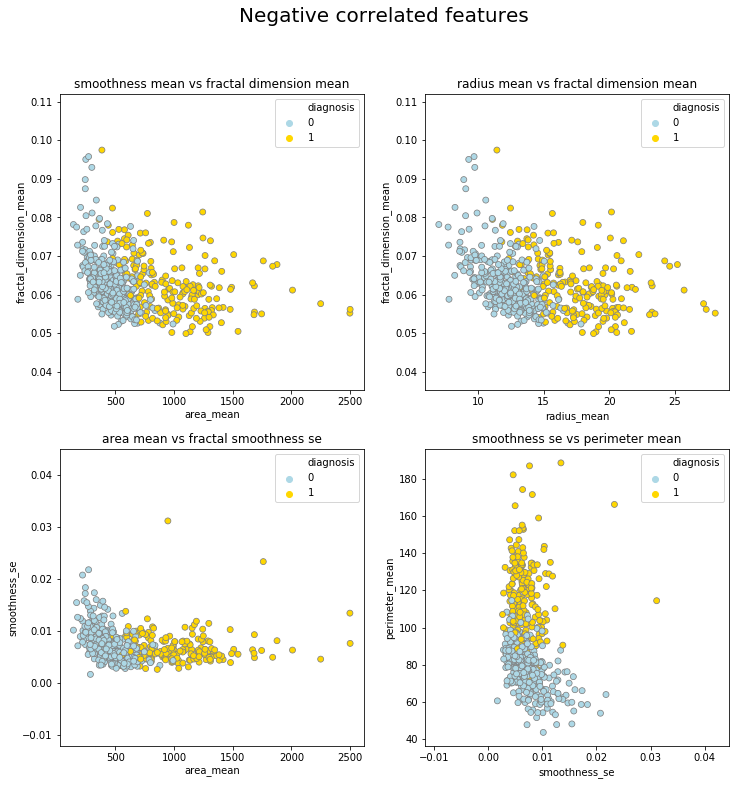

In [54]:
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['area_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['smoothness_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['smoothness_se'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

## Confusion Matrix and Metrics

The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Metrics :

Accuracy : (TP +TN) / (TP + TN + FP +FN)
Precision : TP / (TP + FP)
Recall : TP / (TP + FN)

In [55]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [56]:
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [61]:
# Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [63]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [64]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [79]:
# Def X and Y
y = np.array(data.diagnosis.tolist())
data = data.drop('diagnosis', 1)
X = np.array(data.as_matrix())

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [83]:
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [84]:
# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = random_state)

In [85]:
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits
The best parameters for using this model is {'C': 0.1, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  35 out of  42 | elapsed:   18.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   18.3s finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



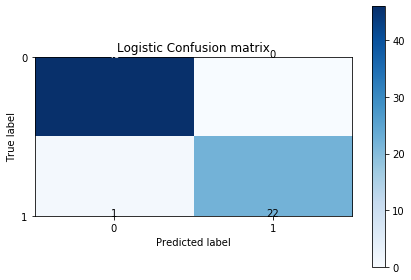

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


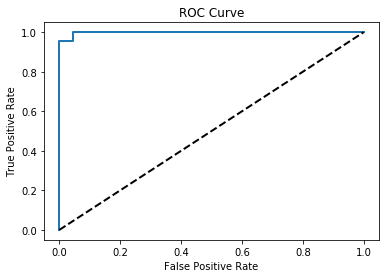

In [86]:
#Log with best hyperparameters
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

Recall w/ threshold = 0.1 : 1.0
Recall w/ threshold = 0.2 : 0.9565217391304348
Recall w/ threshold = 0.3 : 0.9565217391304348
Recall w/ threshold = 0.4 : 0.9565217391304348
Recall w/ threshold = 0.5 : 0.9565217391304348
Recall w/ threshold = 0.6 : 0.9565217391304348
Recall w/ threshold = 0.7 : 0.9565217391304348
Recall w/ threshold = 0.8 : 0.8695652173913043
Recall w/ threshold = 0.9 : 0.782608695652174


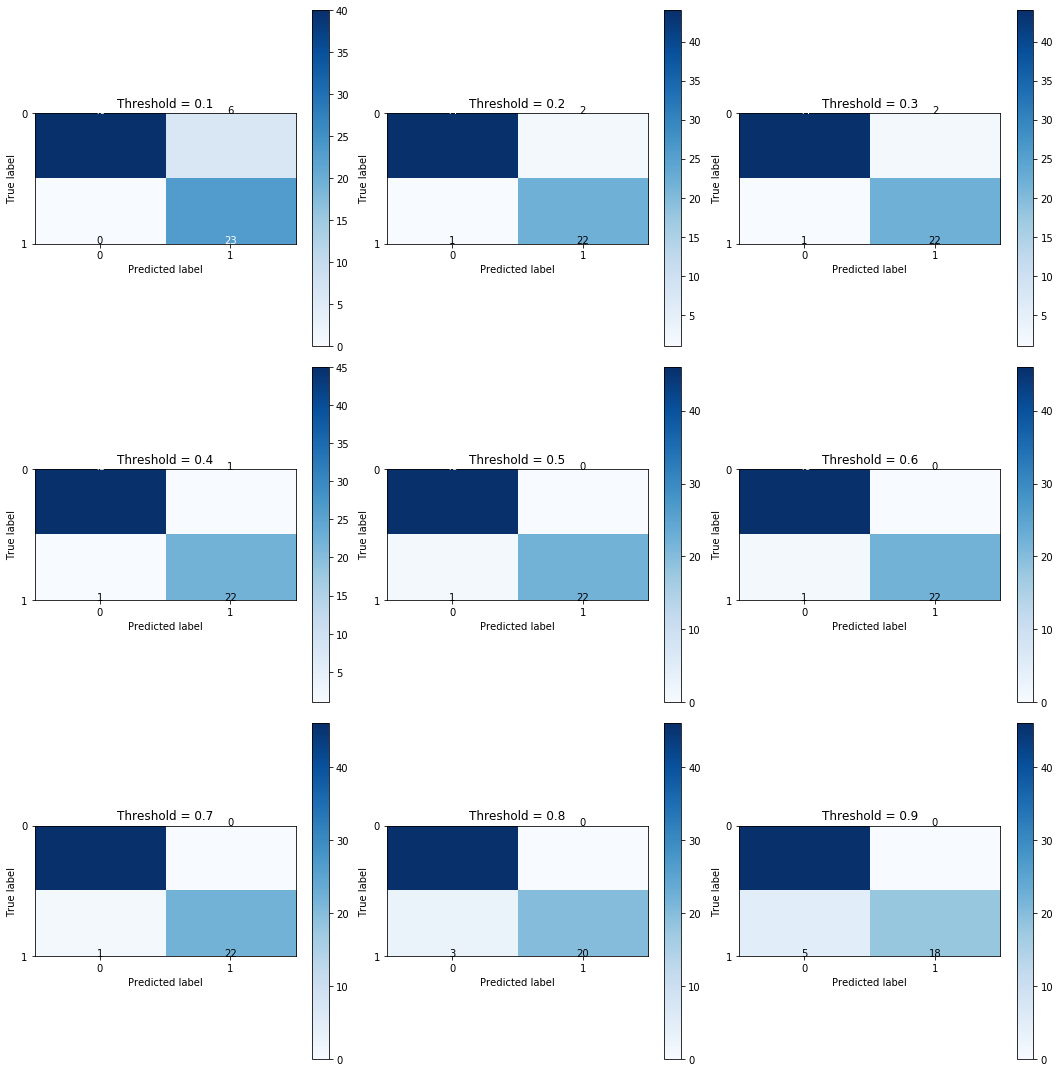

In [87]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

In [88]:
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.1
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()

Accuracy  =     0.913
Precision =     0.793
Recall    =     1.000
F1_score  =     0.885
